### Z1 Results

,model,thread,num_run,hardware,acc_version,del,del_version,valid,acc_layer,cpu_layers,total_latency,acc_layer_cpu,cpu_layers_cpu,total_latency_cpu,acc_layer_speedup,cpu_layers_speedup,total_latency_speedup,name,runname
0,add_simple,1,1,ADD_ACC,2_0,add_delegate,2,1,0.06,0.0,0.06,0.0,0.0,0.0,0,0,0,ADD_v2,ADD_ACC_2_0_add_delegate_2_add_simple_1_1_Z1


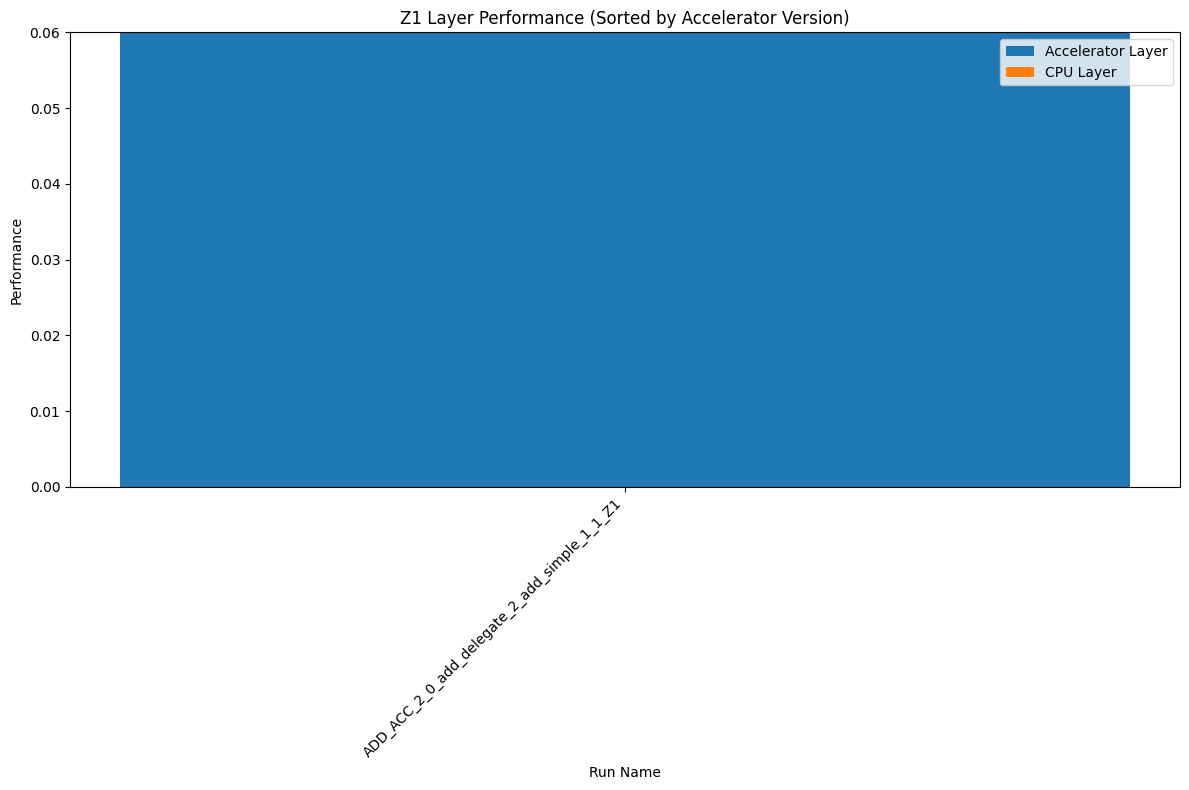

In [3]:
# Benchmarking Suite
%load_ext autoreload
%autoreload 2


import ipywidgets as widgets
import json
import os
from IPython.display import display, Markdown, clear_output
import matplotlib.pyplot as plt
from scripts.configure_utils import *

model_widgets = {}
hardware_widgets = {}
layer_select_widget = None
selected_boards = []

def load_model_config(filename="configs/models.json"):
    with open(filename, "r") as f:
        model_config = json.load(f)

    # catalogue = {"all": []}
    catalogue = {}
    type_catalogue = {}
    for model in model_config["models"]:
        if "layers" in model:
            layers = model["layers"]
            for layer in layers:
                if layer not in catalogue:
                    catalogue[layer] = []
                    type_catalogue[layer] = []
                catalogue[layer].append(model["name"])
                type_catalogue[layer].append(layer)
    return catalogue, type_catalogue

def load_layer_type_config(filename="configs/layer_types.json"):
    with open(filename, "r") as f:
        layer_type_config = json.load(f)

    return layer_type_config["layer_types"]

def parse_model_config_from_file(filename,catalogue,type_catalogue):
    with open(filename, "r") as f:
        model_config = json.load(f)
    for exp_name, model_details in model_config.items():
        models = model_details.get("models", [])
        layer_type = model_details.get("layer_type", "UNKNOWN")
        for model in models:
            if exp_name not in catalogue:
                catalogue[exp_name] = []
                type_catalogue[exp_name] = []
            catalogue[exp_name].append(model)
            type_catalogue[exp_name].append(layer_type)
    return catalogue, type_catalogue

def create_model_selection_widgets(model_catalogue,type_catalogue):
    selected_models = []

    def on_value_change(change):
        selected_models.clear()
        for layer in model_widgets:
            selected_models.extend(model_widgets[layer].children[1].value)
        # selected_models[:] = list(set(selected_models))  # Ensure unique selection


    def select_all_models(layer):
        model_widgets[layer].children[1].value = model_catalogue[layer]

    num_columns = 3  # Number of columns in the grid
    num_rows = (
        len(model_catalogue) + num_columns - 1
    ) // num_columns  # Calculate the number of rows needed

    grid = widgets.GridspecLayout(
        num_rows, num_columns, width="70%", grid_gap="50px"
    )  # Add grid_gap to reduce distance between columns
    row = 0
    col = 0
    for layer in model_catalogue:
        max_model_name_length = max(
            len(model) for models in model_catalogue.values() for model in models
        )
        model_widgets[layer] = widgets.VBox(
            [
                widgets.Label(
                    value=layer, layout=widgets.Layout(margin="0 0 1px 100px")
                ),
                widgets.SelectMultiple(
                    options=model_catalogue[layer],
                    value=[],
                    description="",
                    disabled=False,
                    layout=widgets.Layout(
                        width=f"{max_model_name_length * 9}px", margin="0 0 1px 75px"
                    ),
                ),
                widgets.Button(
                    description=f"All {layer}",
                    layout=widgets.Layout(margin="0 0 1px 75px"),
                    style=widgets.ButtonStyle(),
                ),
            ]
        )
        model_widgets[layer].children[1].observe(on_value_change, names="value")
        model_widgets[layer].children[2].on_click(
            lambda b, l=layer: select_all_models(l)
        )
        grid[row, col] = model_widgets[layer]
        col += 1
        if col == num_columns:
            col = 0
            row += 1

    # display(grid)
    return selected_models, grid

def create_layer_selection_widgets(layer_type_catalogue):
    selected_layers = []

    # Only one widget for all layer types
    def on_value_change(change):
        selected_layers.clear()
        selected_layers.extend(layer_select.value)
        selected_layers[:] = list(set(selected_layers))  # Ensure unique selection

    def select_all_layers(_):
        layer_select.value = tuple(layer_type_catalogue)

    max_layer_name_length = max(len(layer) for layer in layer_type_catalogue)
    layer_label = widgets.Label( value="", layout=widgets.Layout(margin="0 0 1px 100px"))
    layer_select = widgets.SelectMultiple(
        options=layer_type_catalogue,
        value=(layer_type_catalogue[0],) if layer_type_catalogue else (),  # Select first by default
        description="",
        disabled=False,
        layout=widgets.Layout(
            width=f"{max_layer_name_length * 16 + 40}px", margin="0 0 1px 75px"
        ),
    )
    layer_select.observe(on_value_change, names="value")

    select_all_button = widgets.Button(
        description="Select All Layers",
        layout=widgets.Layout(margin="10px 0 10px 100px"),
        style=widgets.ButtonStyle()
    )
    layer_select_widget = layer_select  # Store the widget for later use
    select_all_button.on_click(select_all_layers)
    vbox = widgets.VBox([layer_label,layer_select,select_all_button ])

    return selected_layers, vbox, layer_select

def load_hardware_configs(base_dir="../../hardware_automation/configs"):
    hardware_config = {}

    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".json"):
                file_path = os.path.join(root, file)
                with open(file_path, "r") as f:
                    config = json.load(f)
                    folder_name = os.path.basename(root)
                    if folder_name not in hardware_config:
                        hardware_config[folder_name] = []
                    hardware_config[folder_name].append(
                        {"hardware": file.split(".")[0], "config": config}
                    )
    for entry in hardware_config:
        hardware_config[entry] = sorted(
            hardware_config[entry], key=lambda x: x["hardware"]
        )
    return hardware_config

def configure_benchmark():
    # find the boards we are using through the selected hardwares
    boards = set()
    for hw in selected_hardware:
        for folder, hw_list in hardware_config.items():
            for hw_item in hw_list:
                if hw_item["hardware"] == hw:
                    board = hw_item["config"].get("board", "Z1")
                    boards.add(board)
                    break
    return list(boards)

def update_selected_boards():
    global selected_boards
    selected_boards = configure_benchmark()

    # Create a mapping from board to hardware
    global board_to_hardware_mapping
    board_to_hardware_mapping = {}
    for hw in selected_hardware:
        for folder, hw_list in hardware_config.items():
            for hw_item in hw_list:
                if hw_item["hardware"] == hw:
                    board = hw_item["config"].get("board", "Z1")
                    if board not in board_to_hardware_mapping:
                        board_to_hardware_mapping[board] = []
                    board_to_hardware_mapping[board].append(hw)
                    break

def create_hardware_selection_widgets(hardware_config):
    selected_hardware = []
    def on_value_change(change):
        selected_hardware.clear()
        for folder in hardware_widgets:
            selected_hardware.extend(hardware_widgets[folder].children[1].value)
        selected_hardware[:] = list(set(selected_hardware))  # Ensure unique selection
        update_selected_boards()  # Update selected_boards when selected_hardware is updated

    def select_all_hardware(folder):
        hardware_widgets[folder].children[1].value = [
            hw["hardware"] for hw in hardware_config[folder]
        ]

    num_columns = 3  # Number of columns in the grid
    num_rows = (
        len(hardware_config) + num_columns - 1
    ) // num_columns  # Calculate the number of rows needed

    max_hardware_name_length = max(
        len(hw["hardware"])
        for folder in hardware_config
        for hw in hardware_config[folder]
    )
    grid = widgets.GridspecLayout(
        num_rows, num_columns, width="70%", grid_gap="50px"
    )  # Add grid_gap to reduce distance between columns
    row = 0
    col = 0
    for folder in hardware_config:
        hardware_widgets[folder] = widgets.VBox(
            [
                widgets.Label(
                    value=folder, layout=widgets.Layout(margin="0 0 1px 100px")
                ),
                widgets.SelectMultiple(
                    options=[hw["hardware"] for hw in hardware_config[folder]],
                    value=[],
                    description="",
                    disabled=False,
                    layout=widgets.Layout(
                        width=f"{max_hardware_name_length * 9}px", margin="0 0 1px 75px"
                    ),
                ),
                # widgets.Button(
                #     description=f"All {folder}",
                #     layout=widgets.Layout(margin="0 0 1px 75px"),
                #     style=widgets.ButtonStyle(),
                # ),
            ]
        )
        hardware_widgets[folder].children[1].observe(on_value_change, names="value")
        # hardware_widgets[folder].children[2].on_click(
        #     lambda b, f=folder: select_all_hardware(f)
        # )
        grid[row, col] = hardware_widgets[folder]
        col += 1
        if col == num_columns:
            col = 0
            row += 1
    return selected_hardware , grid

# Load benchmarking suite configurations from a JSON file
def load_widget_values():
  try:
    with open("configs/widget_values.json", "r") as f:
      widget_values = json.load(f)
      init_widget.value = widget_values.get("init", False)
      send_models_widget.value = widget_values.get("send_models", False)
      skip_bench_widget.value = widget_values.get("skip_bench", False)
      bin_gen_widget.value = widget_values.get("bin_gen", False)
      skip_inf_diff_widget.value = widget_values.get("skip_inf_diff", False)
      collect_power_widget.value = widget_values.get("collect_power", False)
      test_run_widget.value = widget_values.get("test_run", False)
      gen_script_widget.value = widget_values.get("gen_run", False)
      name_widget.value = widget_values.get("name", "")
      num_runs_widget.value = widget_values.get("num_runs", 1)
      threads_widget.value = widget_values.get("threads", "1")
      sim_mode_widget.value = widget_values.get("sim_mode", False)
      time_out_widget.value = widget_values.get("timeout", 30)
      layer_select_widget.value = widget_values.get("layer_select", layer_select_widget.value)
      for layer in model_widgets:
        model_widgets[layer].children[1].value = widget_values.get("model_widgets", {}).get(layer, [])
      for folder in hardware_widgets:
        hardware_widgets[folder].children[1].value = widget_values.get("hardware_widgets", {}).get(folder, [])
  except FileNotFoundError:
    print("No saved configuration found.")

# Save benchmarking suite configurations to a JSON file
def save_widget_values():
  widget_values = {
    "init": init_widget.value,
    "send_models": send_models_widget.value,
    "skip_bench": skip_bench_widget.value,
    "bin_gen": bin_gen_widget.value,
    "skip_inf_diff": skip_inf_diff_widget.value,
    "collect_power": collect_power_widget.value,
    "test_run": test_run_widget.value,
    "gen_run": gen_script_widget.value,
    "name": name_widget.value,
    "num_runs": num_runs_widget.value,
    "threads": threads_widget.value,
    "sim_mode": sim_mode_widget.value,
    "layer_select": layer_select_widget.value,
    "model_widgets": {layer: model_widgets[layer].children[1].value for layer in model_widgets},
    "hardware_widgets": {folder: hardware_widgets[folder].children[1].value for folder in hardware_widgets},
    "timeout": time_out_widget.value
  }
  with open("configs/widget_values.json", "w") as f:
    json.dump(widget_values, f)

# =============================================================================
# Load Configurations
# =============================================================================

# Load model configuration from JSON file
model_catalogue , type_catalogue = load_model_config()

# Load model sets from JSON files
for filename in os.listdir("configs/model_sets"):
    if filename.endswith(".json"):
        file_path = os.path.join("configs/model_sets", filename)
        model_catalogue, type_catalogue = parse_model_config_from_file(
            file_path, model_catalogue, type_catalogue
        )

# Load settings and configurations
hardware_config = load_hardware_configs()
layer_type_catalogue = load_layer_type_config()
selected_models, models_grid = create_model_selection_widgets(model_catalogue,type_catalogue)
selected_layers, layer_grid , layer_select_widget= create_layer_selection_widgets(layer_type_catalogue)
selected_hardware, hw_grid = create_hardware_selection_widgets(hardware_config)


# =============================================================================
# SECDA Benchmarking Suite Widgets
# =============================================================================

title = widgets.HTML(
    value="""
    <div style='text-align: center;'>
        <h1 style='margin-bottom: 0px; font-size: 2.5em;'>SECDA Benchmarking Suite</h1>
    </div>
    """
)

# Model Selection Interface
model_title = widgets.HTML(value="<h2 style='margin-bottom: 0px;'>Model Selection Interface</h2>")

# Layer Selection Interface
layer_title = widgets.HTML(value="<h2 style='margin-bottom: 0px;'>Layer Selection Interface</h2>")

# Accelerator Selection Interface
hardware_title = widgets.HTML(value="<h2 style='margin-bottom: 0px;'>Accelerator Selection Interface</h2>")

# Experiment Configuration Interface
benchmark_title = widgets.HTML(value="<h2 style='margin-bottom: 0px;'>Experiment Configuration Interface</h2>")

# Configuration widgets
init_widget = widgets.Checkbox(value=False, description='Initialize boards', layout=widgets.Layout(margin="0 0 0 20px"), style=dict(description_width='initial'))
send_models_widget = widgets.Checkbox(value=False, description='Send models', layout=widgets.Layout(margin="0 0 0 20px"), style=dict(description_width='initial'))
skip_bench_widget = widgets.Checkbox(value=False, description='Skip running experiment', layout=widgets.Layout(margin="0 0 0 20px"), style=dict(description_width='initial'))
bin_gen_widget = widgets.Checkbox(value=False, description='Generate binaries', layout=widgets.Layout(margin="0 0 0 20px"), style=dict(description_width='initial'))
skip_inf_diff_widget = widgets.Checkbox(value=False, description='Skip inference difference checks', layout=widgets.Layout(margin="0 0 0 20px"), style=dict(description_width='initial'))
collect_power_widget = widgets.Checkbox(value=False, description='Power collection', layout=widgets.Layout(margin="0 0 0 20px"), style=dict(description_width='initial'))
test_run_widget = widgets.Checkbox(value=False, description='Test run', layout=widgets.Layout(margin="0 0 0 20px"), style=dict(description_width='initial'))
gen_script_widget = widgets.Checkbox(value=False, description='Generate run scripts', layout=widgets.Layout(margin="0 0 0 20px"), style=dict(description_width='initial'))
name_widget = widgets.Text(value='', description='Name of the experiment', layout=widgets.Layout(margin="0 0 0 20px"), style=dict(description_width='initial'))
num_runs_widget = widgets.IntText(value=1, description='Number of runs', layout=widgets.Layout(margin="0 0 0 20px"), style=dict(description_width='initial'))
threads_widget = widgets.Text(value='1', description='Threads (comma-separated)', layout=widgets.Layout(margin="0 0 0 20px"), style=dict(description_width='initial'))
sim_mode_widget = widgets.Checkbox(value=False, description='Simulation Mode', layout=widgets.Layout(margin="0 0 0 20px"), style=dict(description_width='initial'))
time_out_widget = widgets.IntText(
    value=30,  # Default timeout value
    description='Timeout (s)',
    layout=widgets.Layout(margin="0 0 0 20px"),
    style=dict(description_width='initial')
)

exp_widgets_0 = widgets.HBox([name_widget, num_runs_widget, threads_widget])
exp_widgets_1 = widgets.HBox([init_widget, send_models_widget])
exp_widgets_2 = widgets.HBox([skip_bench_widget, skip_inf_diff_widget,bin_gen_widget,gen_script_widget])
# exp_widgets_3 = widgets.HBox([sim_mode_widget, test_run_widget, collect_power_widget, time_out_widget])
exp_widgets_3 = widgets.HBox([sim_mode_widget, test_run_widget, time_out_widget])


load_button = widgets.Button(description="Load Configuration")
load_button.on_click(lambda b: load_widget_values())

save_button = widgets.Button(description="Save Configuration")
save_button.on_click(lambda b: save_widget_values())

out = widgets.Output(layout=widgets.Layout(
    border='1px solid black', margin='10px', padding='10px'))

console_title = widgets.HTML(
    value="<h1 style='margin-bottom: 0px;'>Benchmarking Suite Console</h1>",
    layout=widgets.Layout(margin="5px 0 0 0")
)

start_terminal = widgets.VBox(
    [console_title, out],
    layout=widgets.Layout(
        border='3px solid black',
        padding='10px',  # Set top/bottom/left/right padding to 0
        margin='10px',
        border_radius='0px',
        box_shadow='2px 2px 10px #aaa'
    )
)
start_button = widgets.Button(description="Start Benchmarking")

exp_widgets = widgets.VBox(
    [
        title,
        model_title,
        models_grid,
        layer_title,
        layer_grid,
        hardware_title,
        hw_grid,
        benchmark_title,
        exp_widgets_0,
        exp_widgets_1,
        exp_widgets_2,
        exp_widgets_3,
        widgets.HBox([load_button, save_button]),
        widgets.VBox([start_button]),
    ],
    layout=widgets.Layout(
        border="3px solid black",
        padding="20px",
        margin="10px",
        border_radius="10px",
        box_shadow="2px 2px 10px #aaa",
    ),
)
exp_children = exp_widgets.children

# =============================================================================
# Run the SECDA Benchmark Suite
# =============================================================================
board_results = {}
def on_button_click(b):
    out.clear_output()
    clear_output(True)
    display(exp_widgets)
    display(start_terminal)
    board_results.clear()
    with out:
      sc = load_config("../../config.json")
      selected_threads = [
          int(thread.strip())
          for thread in threads_widget.value.split(",")
          if thread.strip()
      ]
      selected_num_runs = num_runs_widget.value
      exp_config = {
          "init": init_widget.value,
          "send_models": send_models_widget.value,
          "skip_bench": skip_bench_widget.value,
          "bin_gen": bin_gen_widget.value,
          "skip_inf_diff": skip_inf_diff_widget.value,
          "collect_power": collect_power_widget.value,
          "sim_mode": sim_mode_widget.value,
          "test_run": test_run_widget.value,
          "gen_script": gen_script_widget.value,
          "name": name_widget.value,
          "time_out": time_out_widget.value,
      }
      ret = run_benchmarking_suite(
          sc,
          selected_boards,
          selected_models,
          selected_layers,
          selected_hardware,
          selected_threads,
          selected_num_runs,
          hardware_config,
          exp_config,
          board_results,
          out,
      )

    compared_results = process_compare_with_cpu(board_results)
    for board, result in board_results.items():
        display(Markdown(f"### {board} Results"))
        if 'del_version' in result.columns:
            result['del_version'] = result['del_version'].astype(int)
        if 'model' in result.columns and 'acc_version' in result.columns:
            # Sort by model and then by acc_version
            result_sorted = result.sort_values(by=['model', 'del','del_version'])
            display(result_sorted)

    for board, result in board_results.items():
        if 'acc_layer' in result.columns and 'cpu_layers' in result.columns and 'acc_version' in result.columns:
            # Sort by acc_version and then by model
            result_sorted = result.sort_values(by=['model', 'del','del_version'])
            plt.figure(figsize=(12, 8))
            plt.bar(result_sorted['runname'], result_sorted['acc_layer'], label='Accelerator Layer')
            plt.bar(result_sorted['runname'], result_sorted['cpu_layers'], bottom=result_sorted['acc_layer'], label='CPU Layer')
            plt.title(f'{board} Layer Performance (Sorted by Accelerator Version)')
            plt.xlabel('Run Name')
            plt.ylabel('Performance')
            plt.xticks(rotation=45, ha='right')
            plt.legend()
            plt.tight_layout()
            plt.show()


# Create the buttons
with out:
    start_button.on_click(on_button_click)

display(exp_widgets)
display(start_terminal)
